# Installing dependencies

In [ ]:
# We will use conda for easier installation of PyG
# If only using pip, it somehow takes forever to install on colab 
!pip install -q condacola
import condacolab
condacolab.install()

ERROR: Could not find a version that satisfies the requirement condacola (from versions: none)
ERROR: No matching distribution found for condacola
✨🍰✨ Everything looks OK!


In [ ]:
# Install torch geometric for point-cloud layers
import torch
version = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try: 
    import torch_geometric
except:
    !echo $version
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $version
    import torch_geometric
!pip install rdkit

https://data.pyg.org/whl/torch-1.13.0+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 88.9 MB/s eta 0:00:00


# Importing the dataset

In [ ]:
import torch
import rdkit
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.transforms import NormalizeScale,Distance,NormalizeFeatures
import random
import seaborn as sns
import sklearn.metrics as metrics

In [ ]:
dataset = MoleculeNet(root="./",name="HIV")

Processing...
Done!


# What does the dataset look like?

In [ ]:
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", len(dataset))
print("Dataset sample: ", dataset[0])
print("Sample  nodes: ", dataset[0].num_nodes)
print("Sample  edges: ", dataset[0].num_edges)

Dataset features:  9
Dataset target:  2
Dataset length:  41127
Dataset sample:  Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', y=[1, 1])
Sample  nodes:  19
Sample  edges:  40


CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2 tensor([[0.]])


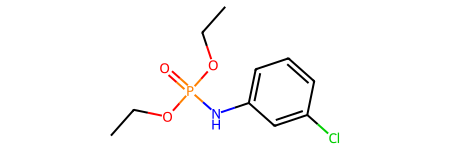

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(dataset[5]["smiles"])
print(dataset[0]["smiles"],dataset[5].y)
molecule

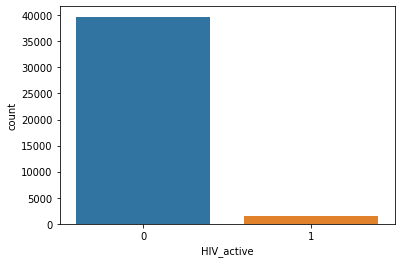

In [ ]:
raw_data = pd.read_csv("/content/hiv/raw/HIV.csv")
sns.countplot(data=raw_data,x="HIV_active")
plt.show()


In [ ]:
classes,counts = np.unique(raw_data["HIV_active"],return_counts=True)
print(classes,counts)
print(counts[1]/counts[0])


[0 1] [39684  1443]
0.03636226186876323


#Sub-sampling the dataset

Splitting into train and testing data

In [53]:
random.seed(1)
true_obs = [obs for obs in dataset if obs.y[0,0] == 1]
false_obs = [obs for i,obs in enumerate(dataset) if obs.y[0,0] == 0]
random.shuffle(true_obs)
random.shuffle(false_obs)

Down-sampling and UP-samling is required when using MSE loss as we are unable to weight the gradients with respect to the class. (With the std. library)

In [55]:
# Down-sampling
sample_data = true_obs + false_obs[:1200]
random.shuffle(sample_data)

# Up-sampling
sample_data = true_obs*int(len(false_obs)/len(true_obs)) + false_obs
random.shuffle(sample_data)
len(sample_data)

78645

In [56]:
from torch_geometric.data import DataLoader
# Wrap data in a data loader
NUM_GRAPHS_PER_BATCH = 256

trainloader = DataLoader(sample_data[:int(len(sample_data)*0.9)],batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
testloader = DataLoader(sample_data[int(len(sample_data)*0.9):],batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# Create model 

In [57]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn as nn
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
embedding_size = 128

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(dataset.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.conv4 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.L1 = Linear(embedding_size*2,int(embedding_size*2/2))
        self.out = Linear(int(embedding_size*2/2), 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = torch.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = torch.tanh(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = torch.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.L1(hidden)
        out = torch.tanh(out)
        out = self.out(out)
        out = torch.sigmoid(out)
        # out = softmax(out,dim=1)
        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
tmp_batch = list(trainloader)[0]
test_output,test_hidden = model(tmp_batch.x.float(),tmp_batch.edge_index,tmp_batch.batch)
print(test_output.shape)

GCN(
  (initial_conv): GCNConv(9, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (conv4): GCNConv(128, 128)
  (L1): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  100353
torch.Size([256, 1])


# Training the model 

In [58]:
from torch_geometric.data import DataLoader
import warnings
random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

def validate(model,test_data):
    # Analyze the results for one batch
    all_ys = []
    all_preds = []
    model.eval()
    for test_batch in test_data:
        with torch.no_grad():
            test_batch.to(device)
            pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
            df = pd.DataFrame()
            all_ys += test_batch.y.tolist()
            all_preds += pred.tolist()
    all_ys = [x[0] for x in all_ys]
    all_preds = [x[0] for x in all_preds]
    fpr, tpr, threshold = metrics.roc_curve(all_ys, all_preds)
    roc_auc = metrics.auc(fpr, tpr)
    return 1-roc_auc,all_preds,all_ys

def validate_binary(model,test_data):
    # Analyze the results for one batch
    all_ys = []
    all_preds = []
    model.eval()
    for test_batch in test_data:
        with torch.no_grad():
            test_batch.to(device)
            pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
            pred = torch.argmax(pred,1)
            df = pd.DataFrame()
            all_ys += test_batch.y.tolist()
            all_preds += pred.tolist()
    all_ys = [x[0] for x in all_ys]
    all_preds = [x for x in all_preds]

    f1 = metrics.f1_score(all_ys, all_preds)
    return 1-f1,all_preds,all_ys



def train(model,N,train_data,val_data):
    # Early stopping
    the_last_loss = 100
    patience = 4
    trigger_times = 0
    val_losses = []
    train_losses = []

    # Enumerate over the data
    for epoch in range(N):
        model.train()
        current_loss = 0

        for batch in train_data:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Passing the node features and the connection info
            pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
            # Calculating the loss and gradients
            # Binary cross entropy optimizer
            # loss = loss_fn(pred, F.one_hot(torch.reshape(batch.y, (-1,)).long(),num_classes=2).float())
            # MSE loss optimizer
            loss = loss_fn(pred, batch.y)
            loss.backward()
            
            # Update using the gradients
            optimizer.step()

            # Save loss
            current_loss += loss.item()
        train_losses.append(current_loss/len((train_data)))
        
        # Early stopping
        validation_loss,val_predictions,val_ys = validate(model,val_data)
        val_losses.append(validation_loss)
        the_current_val_loss = val_losses[-1]

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")

        the_last_val_loss = 0 if len(val_losses) < 2 else val_losses[-2]
        
        if the_current_val_loss > the_last_val_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model,train_losses,val_predictions,val_ys

        else:
            trigger_times = 0

    return model,train_losses,val_predictions,val_ys


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
# Binary cross entropy
# weight = torch.tensor([1,1], dtype=torch.float32).to(device)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)  

# Use GPU for training
model = model.to(device)

print("Starting training...")

model,train_losses,val_predictions,val_ys = train(model,200,trainloader,testloader)

Starting training...
Epoch: 0 Train loss: 0.23904451442754657 Val loss: 0.34832356351455807


KeyboardInterrupt: ignored

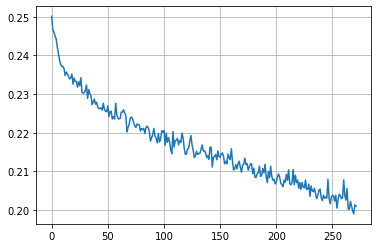

In [ ]:
plt.plot(train_losses)
plt.grid()
plt.show()

# Predictions on validation data

Optimized with BCEloss

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
matrix_confusion = metrics.confusion_matrix(val_ys, val_predictions)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.show()
print(round(metrics.f1_score(val_ys, val_predictions),2))

ValueError: ignored

Optimized with MSEloss

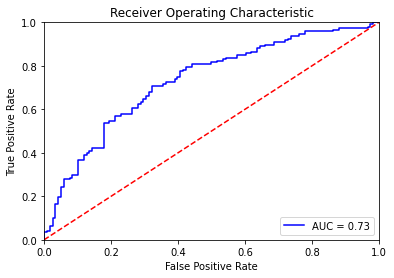

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(val_ys, val_predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
F.one_hot(torch.arange(0, 5))

tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])

In [ ]:
torch.arange(0, 5)

tensor([0, 1, 2, 3, 4])

In [ ]:
batch.y

NameError: ignored

In [ ]:
x = torch.tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 0.])

In [ ]:
F.one_hot(x)

RuntimeError: ignored